In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## Задание 1 (1 балл)

Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации) Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 


In [2]:
from scipy.spatial import distance
import collections

In [3]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.k = n_neighbors
    
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, X):
        y = np.zeros(len(X))
        for i,x in enumerate(X):
            k_neighbors_list = []
            for j, train_x in enumerate(self.X):
                d = distance.minkowski(x, train_x)
                if len(k_neighbors_list) < self.k:
                    k_neighbors_list.append((self.y[j], d))
                else:
                    k_neighbors_list.sort(key=lambda x: x[1])
                    d_max = k_neighbors_list[-1][1]
                    if d < d_max:
                        k_neighbors_list.pop()
                        k_neighbors_list.append((self.y[j], d))
            classes = np.array(k_neighbors_list)[:,0]
            y[i] = collections.Counter(classes.flat).most_common(1)[0][0]
        return y
                
                

In [4]:
iris = datasets.load_iris()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [6]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [7]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [8]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

## Задание 2 (0.5 балла)
Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. Для этого используем numpy.

In [9]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.k = n_neighbors
    
    def fit(self, X, y):
        self.X = X
        self.y = y


    def predict(self, X):
        n = X.shape[0]
        m = self.X.shape[0]
        y_test = np.zeros(n, dtype = self.y.dtype)
        for i, x  in enumerate(X):
            mas = np.tile(x, m).reshape(m,-1)
            distances = np.sqrt(np.sum(np.square(self.X - mas), axis = 1)) 
            sort_index = np.argsort(distances)
            k_indexes = sort_index[:self.k]
            Y_p = self.y[k_indexes]
            y_test[i] =  collections.Counter(Y_p.flat).most_common(1)[0][0]
            
        return y_test

In [10]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [11]:
%time clf.fit(X_train, y_train)

CPU times: user 633 µs, sys: 127 µs, total: 760 µs
Wall time: 719 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [12]:
%time my_clf.fit(X_train, y_train)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 6.91 µs


In [13]:
%time clf.predict(X_test)

CPU times: user 1.7 ms, sys: 58 µs, total: 1.76 ms
Wall time: 1.92 ms


array([1, 0, 0, 0, 2, 2, 1, 1, 0, 2, 2, 1, 2, 0, 2])

In [14]:
%time my_clf.predict(X_test)

CPU times: user 1.83 ms, sys: 951 µs, total: 2.78 ms
Wall time: 2.16 ms


array([1, 0, 0, 0, 2, 2, 1, 1, 0, 2, 2, 1, 2, 0, 2])


## Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. Для этого используем numpy. Точность не должна уступать значению KNN из sklearn.

In [15]:
import sklearn

In [16]:
class MyKNeighborsClassifier(BaseEstimator):
    def __init__(self, n_neighbors, algorithm='brute'):
        self.k = n_neighbors
        self.alg = algorithm
        self.tree = None
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        if self.alg == 'kd_tree':
            self.tree = sklearn.neighbors.KDTree(X)  
    

    def predict(self, X):
        if self.alg == 'brute':
            n = X.shape[0]
            m = self.X.shape[0]
            y_test = np.zeros(n, dtype = self.y.dtype)
            for i, x  in enumerate(X):
                mas = np.tile(x, m).reshape(m,-1)
                distances = np.sqrt(np.sum(np.square(self.X - mas), axis = 1)) 
                sort_index = np.argsort(distances)
                k_indexes = sort_index[:self.k]
                Y_p = self.y[k_indexes]
                y_test[i] =  collections.Counter(Y_p.flat).most_common(1)[0][0]
        if self.alg == 'kd_tree':
            n = X.shape[0]
            y_test = np.zeros(n, dtype = self.y.dtype)
            for i, x  in enumerate(X):
                dist, ind = self.tree.query(x.reshape(1, -1), k=self.k)
                Y_p = self.y[ind]
                y_test[i] =  collections.Counter(Y_p.flat).most_common(1)[0][0]
            
            
        return y_test

In [17]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [18]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [19]:
%time clf.fit(X_train, y_train)

CPU times: user 1.2 ms, sys: 700 µs, total: 1.9 ms
Wall time: 1.36 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [20]:
%time my_clf.fit(X_train, y_train)

CPU times: user 336 µs, sys: 25 µs, total: 361 µs
Wall time: 442 µs


In [21]:
%time clf.predict(X_test)

CPU times: user 2.02 ms, sys: 615 µs, total: 2.64 ms
Wall time: 2.1 ms


array([1, 0, 0, 1, 0, 2, 2, 1, 0, 1, 2, 2, 2, 0, 1])

In [22]:
%time my_clf.predict(X_test)

CPU times: user 2.91 ms, sys: 681 µs, total: 3.59 ms
Wall time: 3.37 ms


array([1, 0, 0, 1, 0, 2, 2, 1, 0, 1, 2, 2, 2, 0, 1])

In [23]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

## Задание 4 (2.5 балла)

In [24]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [25]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью CountVectorizer. Словарь можно ограничить по частотности.

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data)

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [27]:
from sklearn.model_selection import KFold, cross_val_score

In [28]:
cv = KFold(n_splits=3)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах). Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [29]:
first = [x for x in range(1,11)]

In [30]:
import matplotlib.pyplot as plt
def plott(first, score_array):
    plt.plot(first, score_array)
    plt.show()

0.20647001980379184 1


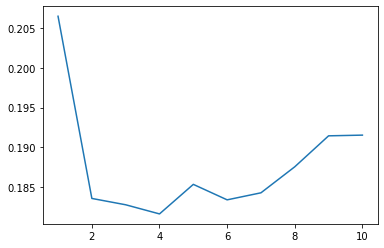

In [31]:
score_array = []
best_score, best_k = None, None
for k in range(1, 11):
    model = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(model, X, target, cv=cv).mean()
    score_array.append(score)
    if best_score is None or score > best_score:
        best_score, best_k = score, k
print(best_score, best_k)
plott(first, score_array)


Как изменится качество на валидации, если:
Используется косинусная метрика вместо евклидовой.
К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)
Сравните модели, выберите лучшую.

Косинусная метрика хорошо подходит для сравнения схожести текстов. Отсюда и лучше качество. Также мера TF-IDF показывает вес слов в каждом векторе, что предоставляет больше информации о тексте, чем подсчет количества вхождений слов.


0.5958995830489591 1


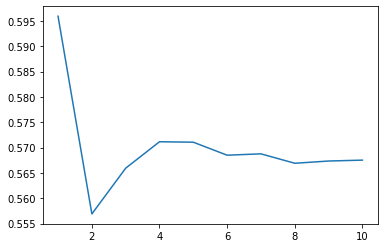

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data)
score_array = []
best_score, best_k = None, None
for k in range(1, 11):
    model = KNeighborsClassifier(n_neighbors=k, metric = 'cosine')
    score = cross_val_score(model, X, target, cv=cv).mean()
    score_array.append(score)
    if best_score is None or score > best_score:
        best_score, best_k = score, k
print(best_score, best_k)
plott(first, score_array)

Загрузим теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [33]:
newsgroups2 = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [34]:
data2 = newsgroups2['data']
target2 = newsgroups2['target']

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [35]:
vectorizer1 = TfidfVectorizer()
X = vectorizer1.fit_transform(data)
vectorizer2 = TfidfVectorizer(vocabulary=vectorizer1.get_feature_names())
X2 = vectorizer2.fit_transform(data2)


In [36]:
model = KNeighborsClassifier(n_neighbors=1, metric = 'cosine')
model.fit(X, target)
y_pred = model.predict(X2)

In [37]:
accuracy_score(y_pred,target2)

0.5050451407328731

Качество отличается. Я взяла число соседей равное 1, которое давало максимум на валидации. Что могло способствовать переобучению. Отсюда и падение качества на тестовой выборке. 